In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

#from lsuv_init import LSUVinit
from datetime import datetime

from tensorflow import keras
from tensorflow_addons.losses import PinballLoss
#from numba import cuda

#cuda.select_device(0)
#cuda.close()

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
    try :
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e :
        print(e)


In [2]:
lookback = 48 * 2
interval = 1

def GHI(data) :
    
    d = data["Day"] % 365
    longitude  = 37.532600
    Tutc = 9
    LSTM = 15 * Tutc
    B = (360 / 365) * (d - 81)
    EoT = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)
    TC = 4 * (127.024612 - LSTM) + EoT
    LST = data["Hour"] + (TC / 60)
    LST[np.array(range(1, LST.shape[0], 2))] += 0.7
    HRA = 15 * (LST- 12)

    theta = np.arcsin(np.sin(23.45) * np.sin(B))
    alpha = np.arcsin(np.sin(theta) * np.sin(longitude) + np.cos(theta) * np.cos(longitude) * np.cos(HRA))
    Zenith = 90 - alpha
    GHI = data["DHI"] + (data["DNI"] * Zenith)
    data.loc[:, "GHI"] = GHI
    
    return

def applyFeatureEngineering(data) :
    data.loc[:, "GHI"] = data["DHI"] + data["DNI"]
    
#    data.loc[:, "DNI"] = np.log(data["DNI"] + 1)
#    data.loc[:, "DHI"] = np.log(data["DHI"] + 1)
#    data.loc[:, "WS"] = np.log(data["WS"] + 1)
#    GHI(data)
#    data.loc[:, "RH"] /= 100
#    formula = np.log(data["RH"]) + (17.62 * data["T"]) / (243.12 + data["T"])
#    data.loc[:, "DP"] = (243.12 * formula) / (17.62 - formula)
#    data.loc[:, "Dew"] = data["T"] - data["DP"]
#    data.loc[:, "WT"] = data["T"] - (data["Dew"] / 3)
    data = data[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "GHI", "TARGET"]]
#    data = pd.concat([data, data.rolling(window = interval, min_periods = 1).mean().drop(["Day", "Hour", "Minute"], axis = "columns").add_suffix("_AVG")], axis = 1)    
    return data



In [3]:
train = pd.read_csv("./RawData/train/train.csv")

train = applyFeatureEngineering(train)

train.describe()


,Day,Hour,Minute,DHI,DNI,RH,WS,T,GHI,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,56.793102,2.456033,9.279928,299.136492,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,22.052875,1.426874,10.179741,392.456413,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,0.000000,-19.000000,0.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,39.697500,1.400000,1.000000,0.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,57.600000,2.200000,9.000000,0.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,72.770000,3.200000,17.000000,655.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,100.000000,12.000000,35.000000,1153.000000,99.913939


In [4]:
class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [6]:
columnsIndex = np.array(range(train.columns.values.shape[0]))[np.isin(train.columns.values, ["TARGET", "RH", "WS", "T", "DHI", "DNI", "GHI"])]

trainFeature_2d = pd.DataFrame(train.iloc[:48 * 48 * 15, columnsIndex].reset_index(drop = True), columns = train.columns[columnsIndex])
trainTarget_2d = train["TARGET"].iloc[:48 * 48 * 15]
trainTarget_2d = pd.DataFrame(trainTarget_2d.values.reshape(-1, 1), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(train.iloc[48 * 48 * 15:, columnsIndex].reset_index(drop = True), columns = train.columns[columnsIndex])
validTarget_2d = train["TARGET"].iloc[48 * 48 * 15:]
validTarget_2d = pd.DataFrame(validTarget_2d.values.reshape(-1, 1), index = validFeature_2d.index)

featureScaler = DecimalScaler()
targetScaler = DecimalScaler()

trainFeature_2d = pd.DataFrame(featureScaler.fit_transform(trainFeature_2d), index = trainFeature_2d.index, columns = train.columns[columnsIndex])
trainTarget_2d = pd.DataFrame(targetScaler.fit_transform(trainTarget_2d), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(featureScaler.transform(validFeature_2d), index = validFeature_2d.index, columns = train.columns[columnsIndex])
validTarget_2d = pd.DataFrame(targetScaler.transform(validTarget_2d), index = validFeature_2d.index)

In [131]:
def makeTimeData(feature, target, timeStep, slideSize) :
    """
    timeStep  : How many "times" will LSTM look back? (Standard : 30 minutes)
                if timeStep value is 336, LSTM will predict target value with past 7 days
    slideSize : Period of standard in time series
    """
    
    newFeature = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, timeStep, feature.shape[1]))
#    newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96, 1))
    newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96))

    for i in range(newFeature.shape[0]) :
        newFeature[i] = feature.iloc[(i * slideSize) : (i * slideSize) + timeStep, :]
        newTarget[i] = target.iloc[(i * slideSize) + timeStep : (i * slideSize) + timeStep + 96].values.reshape(-1)

    newFeature = tf.convert_to_tensor(newFeature)
    newTarget = tf.convert_to_tensor(newTarget)
        
    return newFeature, newTarget

trainFeature, trainTarget = makeTimeData(trainFeature_2d, trainTarget_2d, lookback, interval)
validFeature, validTarget = makeTimeData(validFeature_2d, validTarget_2d, lookback, interval)

trainARFeature, trainARTarget = makeTimeData(pd.DataFrame(trainFeature_2d["TARGET"]), trainTarget_2d, lookback, interval)
validARFeature, validARTarget = makeTimeData(pd.DataFrame(validFeature_2d["TARGET"]), validTarget_2d, lookback, interval)

trainTarget_2d = trainTarget_2d.shift(-96).dropna().reset_index(drop = True)
validTarget_2d = validTarget_2d.shift(-96).dropna().reset_index(drop = True)

trainFeature_2d = trainFeature_2d.iloc[:trainFeature_2d.shape[0] - 96, :].reset_index(drop = True)
validFeature_2d = validFeature_2d.iloc[:validFeature_2d.shape[0] - 96, :].reset_index(drop = True)

In [145]:
batch_size = 32
n_recur = 12
n_conv = 128

def TPA(n_recur, n_conv, batch_size, tau) :
    InputLayer = keras.layers.Input(shape = (trainFeature.shape[1], trainFeature.shape[2]), batch_size = batch_size)

    h_state, c_state, recur_output = keras.layers.LSTM(n_recur, return_sequences = True, return_state = True, stateful = True, recurrent_initializer = "glorot_normal")(InputLayer)
    h_state = keras.layers.Permute((2, 1))(h_state)

    conv = keras.layers.Conv1D(filters = n_conv, kernel_size = 1, strides = 1, use_bias = False, padding = "valid", activation = "relu")(h_state)

    weighted_output = keras.layers.Dense(n_conv, use_bias = False, activation = "linear")(recur_output)
    weighted_output = keras.backend.expand_dims(weighted_output, axis = 2)

    dot = keras.layers.Dot(axes = (2, 1))([conv, weighted_output])

    alpha = keras.layers.Activation("sigmoid")(dot)

    multiply = keras.layers.Multiply()([alpha, conv])
    context_vector = tf.reduce_sum(multiply, axis = 1)

    weighted_recur = keras.layers.Dense(n_recur, use_bias = False, activation = "linear")(recur_output)
    weighted_cont_vec = keras.layers.Dense(n_recur, use_bias = False, activation = "linear")(context_vector)

    add = keras.layers.Add()([weighted_recur, weighted_cont_vec])

    OutputLayer = keras.layers.Dense(96, activation = "linear", use_bias = False)(add)

    model = keras.models.Model(inputs = InputLayer, outputs = OutputLayer)
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.005)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])
    return model

In [146]:
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, restore_best_weights = True)
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 10, verbose = 1, min_delta = 0.0005)

modelList = {}
for i in range(5, 6) :
    modelList[str(np.round(i * .1, decimals = 1))] = TPA(n_recur = n_recur, n_conv = n_conv, batch_size = batch_size, tau = np.round(i * .1, decimals = 1))
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit(trainFeature, trainTarget, epochs = 200, shuffle = False,
                                                       validation_data = (validFeature[:-16], validTarget[:-16]), batch_size = batch_size, callbacks = [lr, es])

Tau : 0.5
Epoch 1/200
1071/1071 [==============================] - 14s 13ms/step - loss: 0.0474 - mae: 0.0948 - val_loss: 0.0456 - val_mae: 0.0912
Epoch 2/200
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0376 - mae: 0.0752 - val_loss: 0.0469 - val_mae: 0.0937
Epoch 3/200
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0359 - mae: 0.0717 - val_loss: 0.0497 - val_mae: 0.0995
Epoch 4/200
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0350 - mae: 0.0700 - val_loss: 0.0499 - val_mae: 0.0998
Epoch 5/200
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0345 - mae: 0.0690 - val_loss: 0.0514 - val_mae: 0.1029
Epoch 6/200
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0340 - mae: 0.0681 - val_loss: 0.0496 - val_mae: 0.0992
Epoch 7/200
1071/1071 [==============================] - 12s 11ms/step - loss: 0.0336 - mae: 0.0673 - val_loss: 0.0494 - val_mae: 0.0988
Epoch 8/200
1071/1071 [========

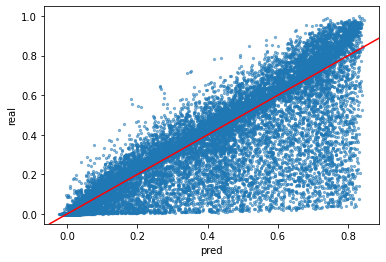

In [147]:
result = modelList["0.5"].predict(trainFeature)
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = trainTarget[np.arange(trainTarget.shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

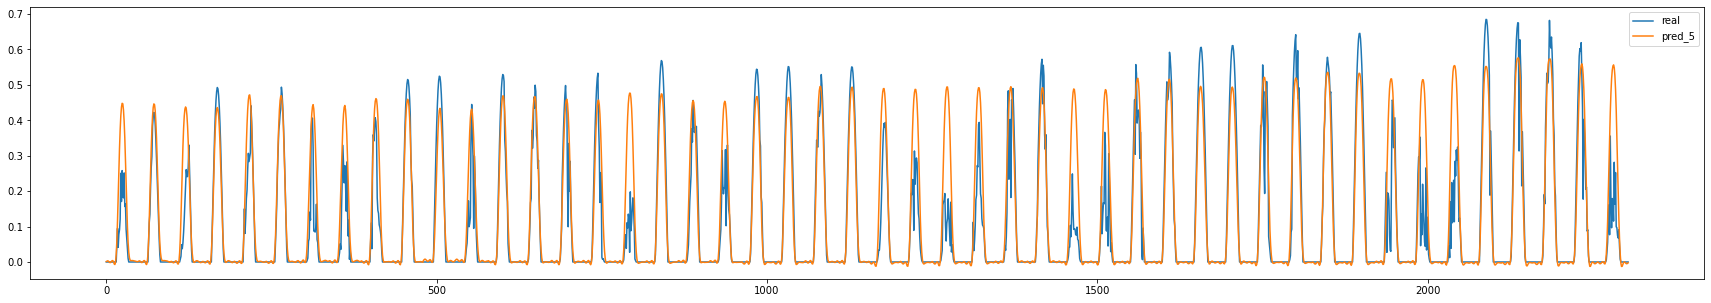

In [150]:
start = 0
end = 48
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8"

#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

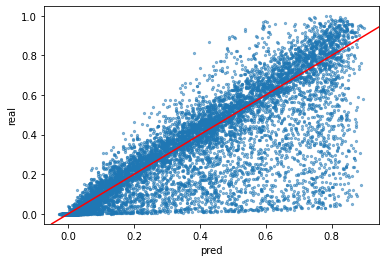

In [141]:
result = modelList["0.5"].predict(validFeature[:-16])
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = validTarget[:-16][np.arange(validTarget[:-16].shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

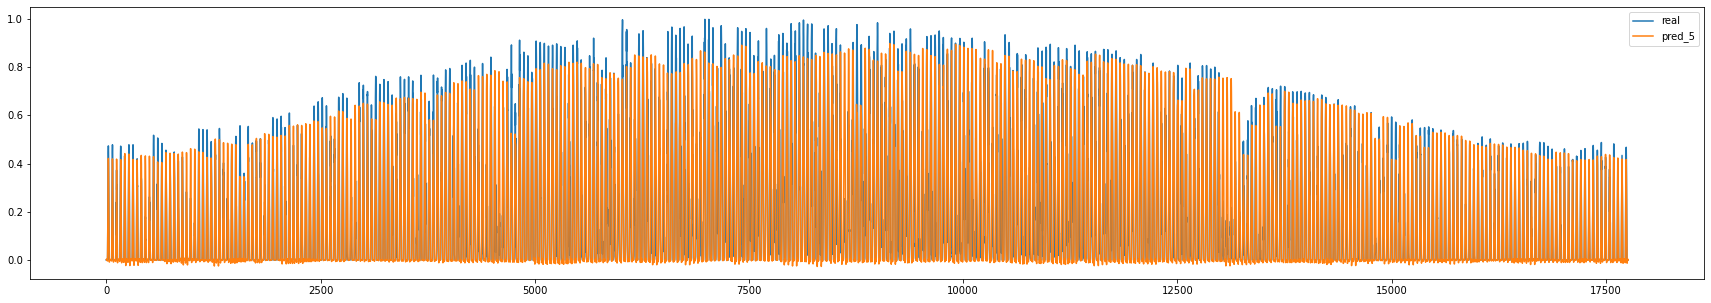

In [142]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()